# 🧠 pengolahan bahasa alami (pba) — kelas a  

**nrp:** 5026221144  
**nama:** alfa renaldo aluska  

---

### 📘 pba2025gasal  

#### ✳️ eda & analisis sentimen data ulasan — transjogja  

**deskripsi singkat:**  
notebook ini berisi eksplorasi data awal (eda) dan visualisasi hasil analisis sentimen pada dataset ulasan pengguna layanan **transjogja**.  
seluruh proses fokus pada pemahaman distribusi sentimen, karakteristik teks, serta pola kata yang dominan di tiap kategori.

---

**langkah-langkah utama:**  
1. import library dan load dataset hasil preprocessing  
2. analisis distribusi label sentimen (positif, netral, negatif)  
3. analisis panjang teks dan jumlah kata  
4. visualisasi wordcloud per sentimen (tanpa duplikasi visual)  
5. identifikasi kata & bigram paling sering muncul per label  
6. analisis hubungan antara panjang teks dan label sentimen  
7. korelasi antar fitur numerik (jika ada)  
8. identifikasi kata unik khas tiap label  
9. representasi tf-idf + pca untuk melihat kluster sentimen  
10. insight singkat di akhir untuk rekap hasil analisis  

---

**catatan:**  
- kolom utama yang digunakan: `final_text` dan `score_label`  
- visualisasi wordcloud sudah diatur agar kata berulang tidak tampil ganda  
- hasil analisis bersifat eksploratif untuk mendukung tahap modeling selanjutnya


In [17]:
# import library wajib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from nltk.probability import FreqDist
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# download resource nltk biar aman
nltk.download('punkt')

# load data
df = pd.read_csv('/content/df_transjog_clean_label.csv')

# ambil teks bersih
df = df.dropna(subset=['final_text'])
texts = df['final_text']

# tambahin kolom jumlah kata
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#1️⃣ distribusi label sentimen

bagian ini nunjukin sebaran label sentimen di dataset, kayak berapa banyak review positif, negatif, dan netral.
tujuannya biar tau data seimbang apa enggak. kalau misalnya positifnya kebanyakan, nanti model bisa bias ke positif.
visualisasinya pake bar chart biar langsung keliatan proporsinya.

/tmp/ipython-input-988778448.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='score_label', palette='coolwarm')


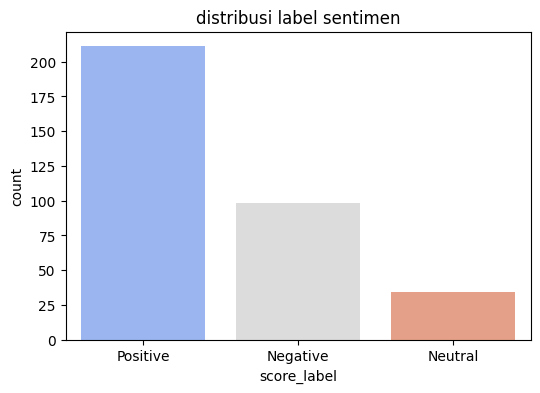

In [18]:
# ===========================================================
# 1️⃣ distribusi sentimen
# ===========================================================
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='score_label', palette='coolwarm')
plt.title('distribusi label sentimen')
plt.show()


#2️⃣ distribusi panjang teks

di sini dicek seberapa panjang review-review yang ada, dilihat dari jumlah kata.
kalau mayoritas review pendek (misal 1–3 kata), berarti kontennya simpel, bisa pengaruh ke kualitas analisis.
kalo ada banyak yang panjang, bisa nunjukin review detail atau curhatan user.
biasanya divisualin pake histogram + kde (density curve).

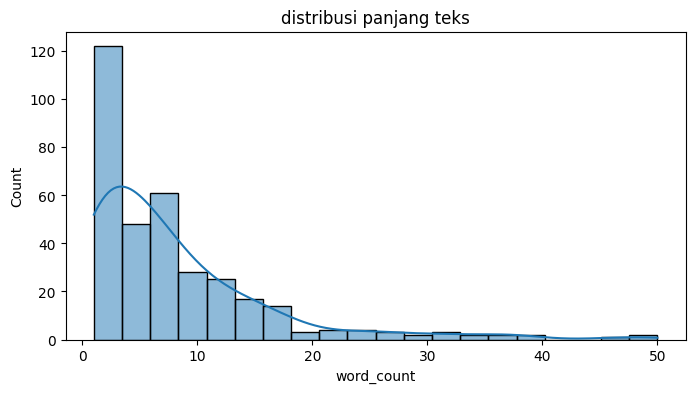

In [19]:
# ===========================================================
# 2️⃣ distribusi panjang teks
# ===========================================================
plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=20, kde=True)
plt.title('distribusi panjang teks')
plt.show()


#3️⃣ wordcloud per sentimen

bagian ini buat liat kata apa yang paling sering muncul di tiap sentimen.
wordcloud bantu buat identifikasi kata dominan dengan visual ukuran font: makin gede, makin sering muncul.
misal di sentimen positif sering muncul “mantap”, “bagus”, “cepat”, sedangkan negatif muncul “lama”, “error”, “ngeleg”.

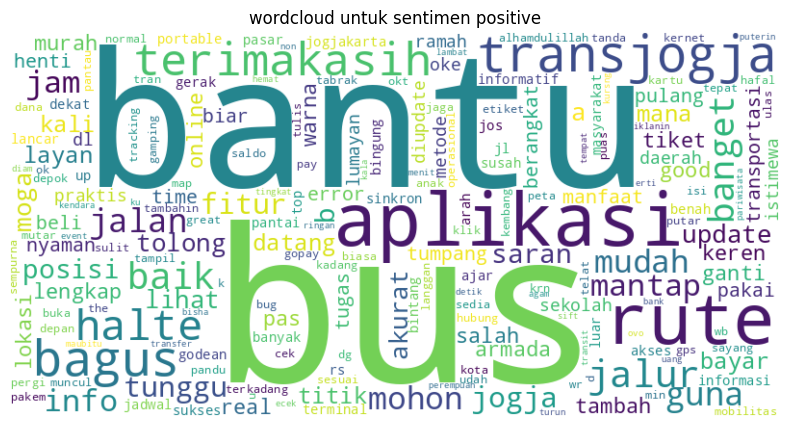

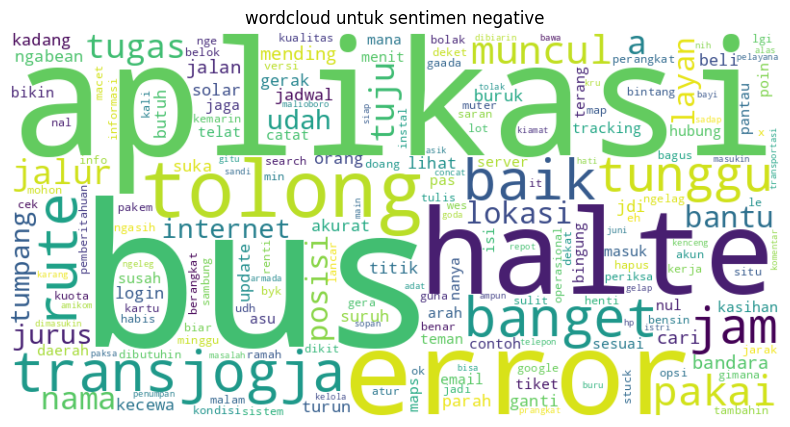

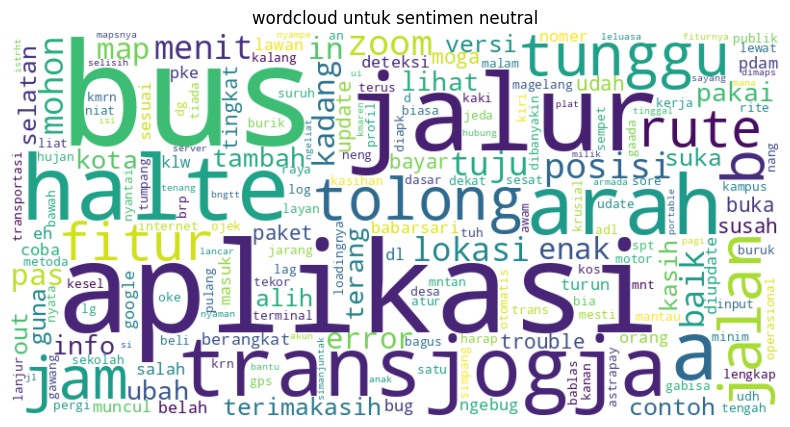

In [20]:
# ===========================================================
# 3️⃣ wordcloud per sentimen (tanpa duplikasi visual)
# ===========================================================
for label in df['score_label'].unique():
    texts = ' '.join(df[df['score_label']==label]['final_text']).split()
    freq = Counter(texts)  # ngitung frekuensi kata, otomatis gabung yang sama
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'wordcloud untuk sentimen {label.lower()}')
    plt.show()

#4️⃣ top kata per sentimen

di sini dihitung 15 kata paling sering di tiap kategori (positif, negatif, netral).
hasilnya divisualin pake bar chart biar keliatan frekuensinya jelas.
tujuannya buat ngeliat pola umum: apa sih yang paling sering diomongin orang di tiap jenis emosi.
ini juga bisa bantu kalau nanti mau bikin kamus kata khas per label.

/tmp/ipython-input-2502642425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in common], y=[x[1] for x in common], palette='viridis')


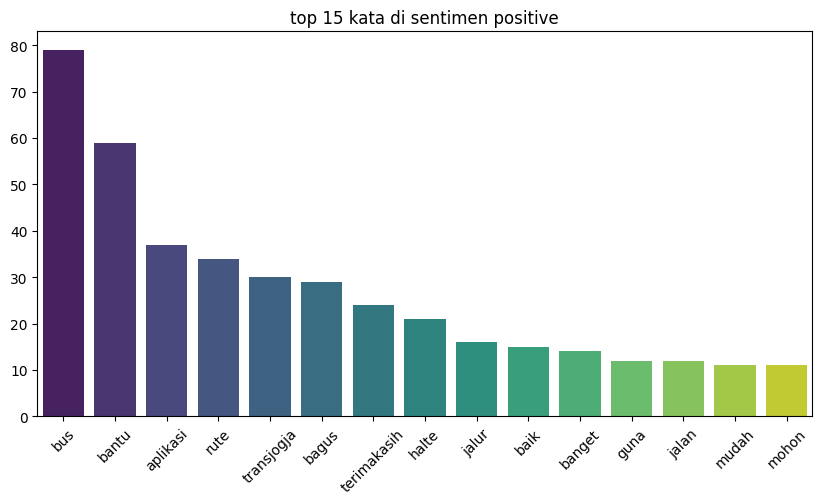

/tmp/ipython-input-2502642425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in common], y=[x[1] for x in common], palette='viridis')


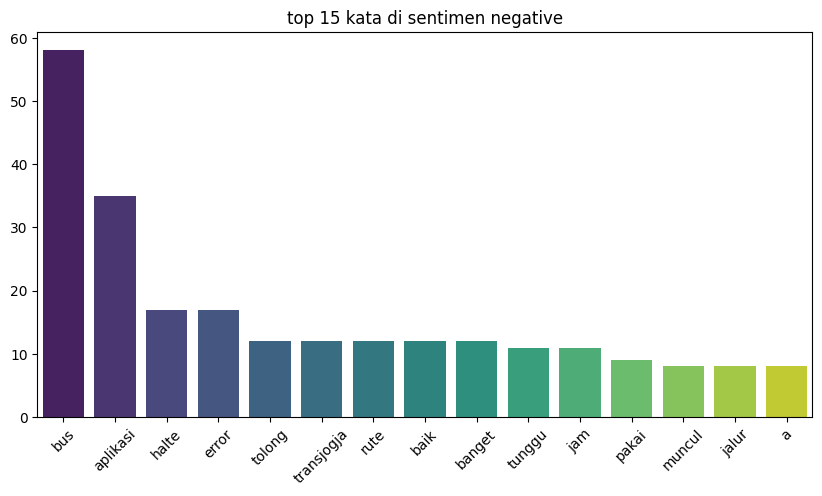

/tmp/ipython-input-2502642425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in common], y=[x[1] for x in common], palette='viridis')


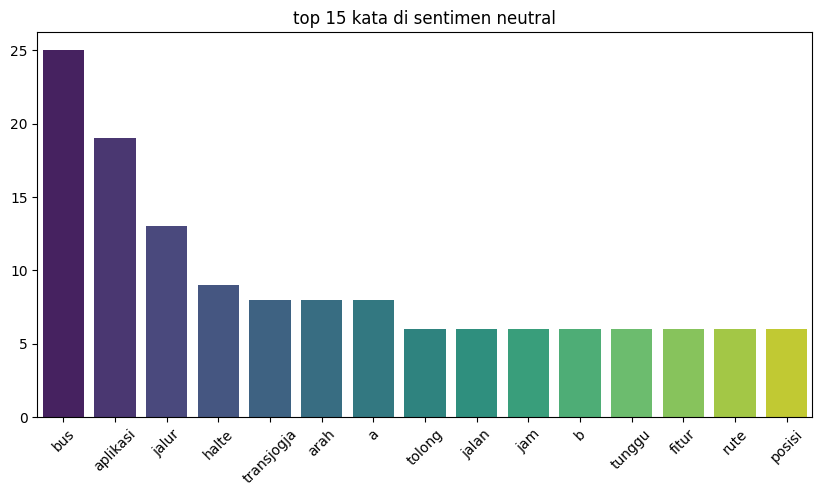

In [21]:
# ===========================================================
# 4️⃣ top kata per sentimen
# ===========================================================
for label in df['score_label'].unique():
    words = ' '.join(df[df['score_label']==label]['final_text']).split()
    fdist = FreqDist(words)
    common = fdist.most_common(15)
    plt.figure(figsize=(10,5))
    sns.barplot(x=[x[0] for x in common], y=[x[1] for x in common], palette='viridis')
    plt.title(f'top 15 kata di sentimen {label.lower()}')
    plt.xticks(rotation=45)
    plt.show()

#5️⃣ bigram per sentimen

analisis ini fokus ke dua kata yang sering muncul berurutan (bigram).
contohnya “sangat bagus”, “tidak berfungsi”, “pelayanan cepat”.
bigram bisa ngasih konteks yang gak keliatan kalau cuma liat kata tunggal,
misal “tidak bagus” beda banget maknanya sama “bagus”.
grafiknya bar chart 10 besar kombinasi kata yang paling sering muncul per label.

/tmp/ipython-input-4102516352.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[' '.join(b[0]) for b in freq], y=[b[1] for b in freq], palette='magma')


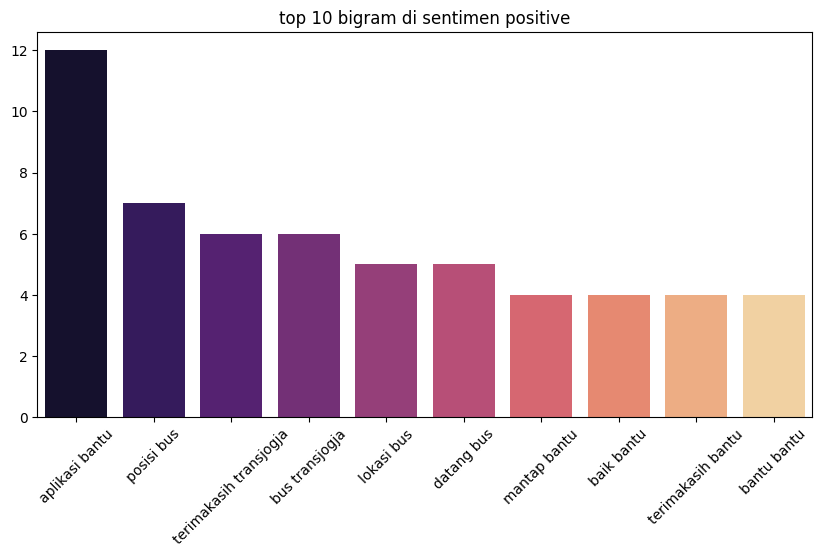

/tmp/ipython-input-4102516352.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[' '.join(b[0]) for b in freq], y=[b[1] for b in freq], palette='magma')


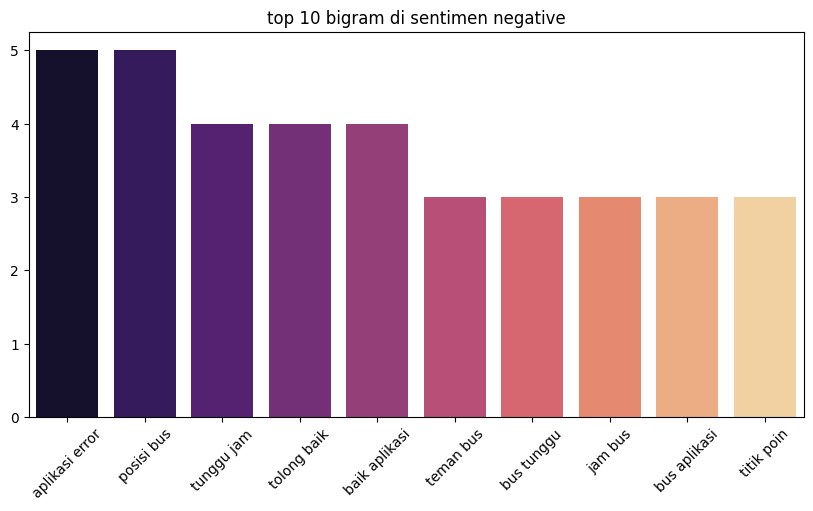

/tmp/ipython-input-4102516352.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[' '.join(b[0]) for b in freq], y=[b[1] for b in freq], palette='magma')


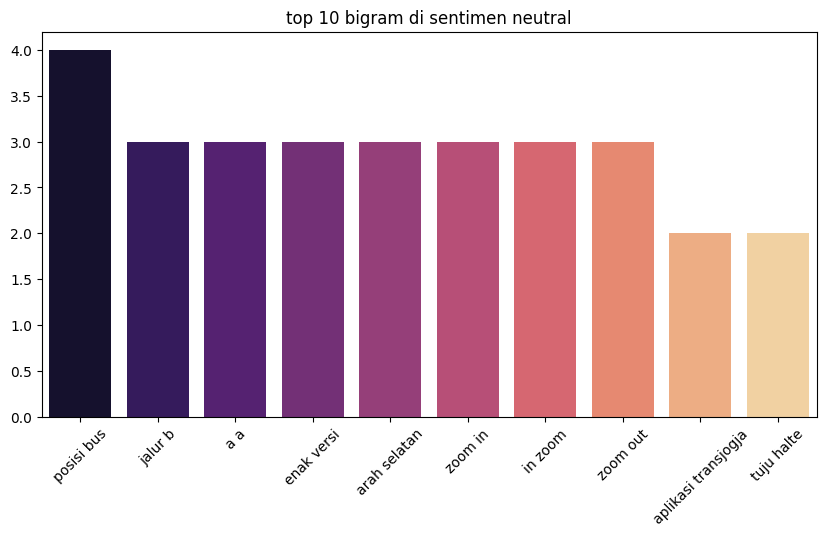

In [22]:
# ===========================================================
# 5️⃣ bigram per sentimen
# ===========================================================
for label in df['score_label'].unique():
    words = ' '.join(df[df['score_label']==label]['final_text']).split()
    bigrams = list(ngrams(words, 2))
    freq = Counter(bigrams).most_common(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=[' '.join(b[0]) for b in freq], y=[b[1] for b in freq], palette='magma')
    plt.title(f'top 10 bigram di sentimen {label.lower()}')
    plt.xticks(rotation=45)
    plt.show()

#6️⃣ hubungan panjang teks sama label

di bagian ini dicek apakah review positif cenderung lebih panjang atau lebih pendek daripada yang negatif.
dipake boxplot buat liat median dan sebarannya.
kadang review negatif itu lebih panjang karena orang ngeluh lebih detail,
sementara yang puas cuma nulis “mantap” atau “bagus banget”.

/tmp/ipython-input-1517969331.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='score_label', y='word_count', palette='cool')


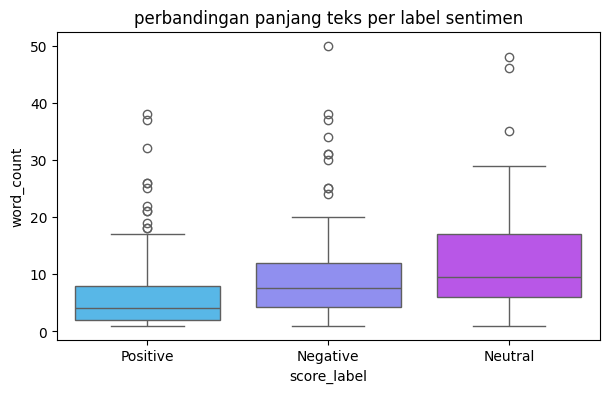

In [23]:
# ===========================================================
# 6️⃣ hubungan panjang teks dan label
# ===========================================================
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='score_label', y='word_count', palette='cool')
plt.title('perbandingan panjang teks per label sentimen')
plt.show()

#7️⃣ korelasi antar fitur numerik

kalau dataset punya kolom numerik lain (kayak score, thumbsUpCount, text_length, dll),
di sini dicek korelasinya pakai heatmap.
bisa keliatan misalnya: apakah score tinggi biasanya punya banyak like,
atau review panjang cenderung dapet nilai tertentu.

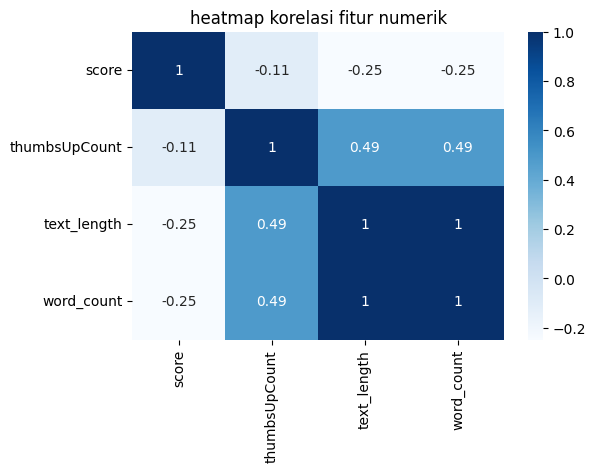

In [24]:
# ===========================================================
# 7️⃣ korelasi antar fitur numerik (kalau ada)
# ===========================================================
num_cols = df.select_dtypes(include=np.number)
if len(num_cols.columns) > 1:
    plt.figure(figsize=(6,4))
    sns.heatmap(num_cols.corr(), annot=True, cmap='Blues')
    plt.title('heatmap korelasi fitur numerik')
    plt.show()

#8️⃣ kata unik per label

analisis ini cari kata yang khas di tiap label. kata yang cuma muncul di kategori tertentu dan gak muncul di label lain.
hasilnya bantu banget buat ngerti “vocabulary khas” tiap emosi.
misalnya kata “error” mungkin cuma muncul di negatif, “terima kasih” di positif.
ini bisa jadi insight linguistik atau buat fitur NLP lanjutan.

In [25]:
# ===========================================================
# 8️⃣ kata unik per label
# ===========================================================
label_groups = df.groupby('score_label')['final_text'].apply(lambda x: ' '.join(x)).to_dict()
all_words = {label: set(text.split()) for label, text in label_groups.items()}

for label in all_words:
    others = set().union(*[v for k,v in all_words.items() if k!=label])
    unique = all_words[label] - others
    print(f'\n🔹 kata khas di {label.lower()} (contoh 10):', list(unique)[:10])



🔹 kata khas di negative (contoh 10): ['habis', 'bilang', 'kya', 'menimati', 'penuh', 'ne', 'moovit', 'c', 'lagak', 'responsif']

🔹 kata khas di neutral (contoh 10): ['signal', 'pdam', 'istrht', 'kledokan', 'mntan', 'gawang', 'kaki', 'tuh', 'ui', 'jempol']

🔹 kata khas di positive (contoh 10): ['barat', 'sm', 'ngeceknya', 'jmlah', 'ros', 'shopeepay', 'samas', 'semenjak', 'ovo', 'up']


#9️⃣ tf-idf + pca buat visualisasi kluster

bagian ini masuk ke analisis vektor teks.
semua review diubah jadi vektor tf-idf (representasi bobot kata),
terus direduksi dimensinya pakai PCA biar bisa divisualin di grafik 2D.
hasilnya nunjukin seberapa jelas cluster antar sentimen.
kalau titik-titiknya kebentuk kelompok rapi, berarti tiap sentimen punya ciri kata kuat.

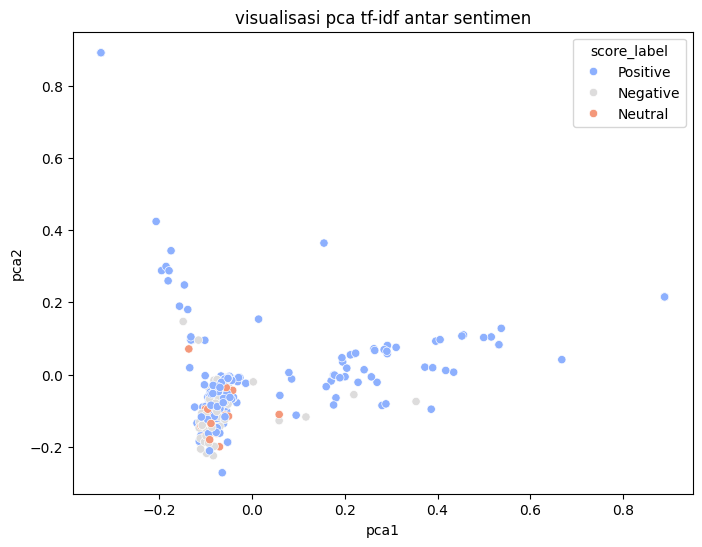

In [26]:
# ===========================================================
# 9️⃣ tf-idf + pca buat liat kluster sentimen (visual 2d)
# ===========================================================
tfidf = TfidfVectorizer(max_features=300)
X = tfidf.fit_transform(df['final_text'])
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

df['pca1'] = reduced[:,0]
df['pca2'] = reduced[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='score_label', palette='coolwarm')
plt.title('visualisasi pca tf-idf antar sentimen')
plt.show()


#🔟 insight ringkasan akhir

bagian terakhir buat nyimpulin hasil EDA secara umum.
isinya info kayak jumlah data, rata-rata panjang teks, kata paling sering muncul,
jumlah per label, dan bigram paling populer.

In [27]:
# ===========================================================
#  🔟 insight cepet di akhir biar keren
# ===========================================================
print('\n=== insight singkat ===')
print('jumlah data:', len(df))
print('rata-rata panjang teks:', round(df["word_count"].mean(), 2))
print('jumlah kata unik total:', len(set(" ".join(df["final_text"]).split())))
for label in df['score_label'].unique():
    print(f"- total {label.lower()}: {len(df[df['score_label']==label])}")


=== insight singkat ===
jumlah data: 343
rata-rata panjang teks: 7.95
jumlah kata unik total: 913
- total positive: 211
- total negative: 98
- total neutral: 34


#1️⃣1️⃣ analisis panjang teks per label

visualisasi distribusi panjang teks dipisah per kategori sentimen.
tujuannya buat liat apakah review positif, netral, atau negatif cenderung lebih panjang atau pendek.

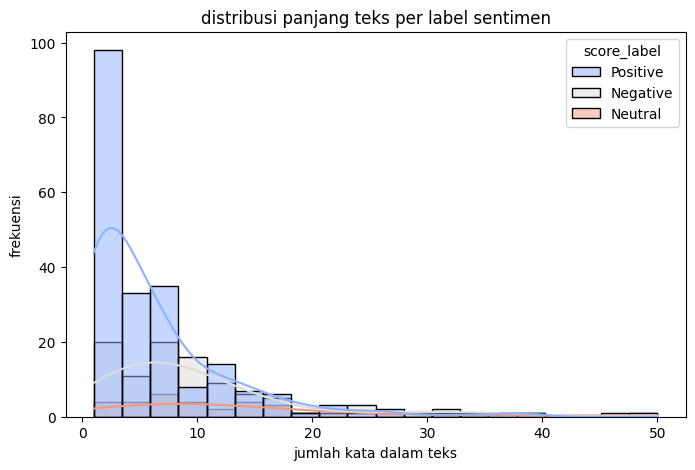

In [28]:
# ===========================================================
# 1️⃣1️⃣ analisis panjang teks per label (lebih detail)
# ===========================================================
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='word_count', hue='score_label', bins=20, kde=True, palette='coolwarm')
plt.title('distribusi panjang teks per label sentimen')
plt.xlabel('jumlah kata dalam teks')
plt.ylabel('frekuensi')
plt.show()

#1️⃣2️⃣ analisis rare words (kata langka)

bagian ini ngitung kata-kata yang cuma muncul satu kali di seluruh dataset.
kata langka bisa nunjukin ekspresi unik yang jarang dipakai user, tapi juga bisa jadi noise.

In [29]:
# ===========================================================
# 1️⃣2️⃣ analisis rare words (kata yang sangat jarang)
# ===========================================================
all_words = ' '.join(df['final_text']).split()
word_freq = Counter(all_words)
rare_words = [w for w, c in word_freq.items() if c == 1]
print('jumlah kata yang cuma muncul sekali:', len(rare_words))
print('contoh kata langka:', rare_words[:10])

jumlah kata yang cuma muncul sekali: 575
contoh kata langka: ['hemat', 'uang', 'ringan', 'transfer', 'bank', 'ovo', 'agam', 'nih', 'masukin', 'kenceng']


#1️⃣3️⃣ proporsi tiap label sentimen

ngeliatin perbandingan persentase tiap label (positif, negatif, netral).
biar tau apakah data seimbang atau bias ke salah satu sisi sentimen.

In [30]:
# ===========================================================
# 1️⃣3️⃣ proporsi tiap label sentimen
# ===========================================================
print('\nproporsi tiap label sentimen (%):')
print((df['score_label'].value_counts(normalize=True) * 100).round(2))


proporsi tiap label sentimen (%):
score_label
Positive    61.52
Negative    28.57
Neutral      9.91
Name: proportion, dtype: float64


#1️⃣4️⃣ top kata khas berdasarkan tf-idf per label

pakai tf-idf buat ngambil kata paling “berciri” di tiap label.
misal, kata yang kuat muncul di positif tapi jarang di negatif akan dapet skor tf-idf tinggi di positif.

In [31]:
# ===========================================================
# 1️⃣4️⃣ top kata khas berdasarkan TF-IDF per label
# ===========================================================
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['final_text'])
feature_names = np.array(tfidf.get_feature_names_out())

for label in df['score_label'].unique():
    idx = df['score_label'] == label
    # ubah ke array numpy biar bisa indexing
    mean_tfidf = X[idx.values].mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[-10:][::-1]

    print(f'\n🔹 top 10 kata khas (nilai tf-idf tertinggi) untuk {label.lower()}:')
    print(feature_names[top_idx])



🔹 top 10 kata khas (nilai tf-idf tertinggi) untuk positive:
['bantu' 'bagus' 'bus' 'aplikasi' 'baik' 'transjogja' 'terimakasih'
 'mantap' 'guna' 'rute']

🔹 top 10 kata khas (nilai tf-idf tertinggi) untuk negative:
['bus' 'error' 'aplikasi' 'baik' 'banget' 'rute' 'halte' 'tolong' 'jam'
 'tunggu']

🔹 top 10 kata khas (nilai tf-idf tertinggi) untuk neutral:
['bus' 'jalur' 'aplikasi' 'tunggu' 'mohon' 'posisi' 'tolong' 'jam'
 'lokasi' 'arah']


#1️⃣5️⃣ hubungan kata unik vs panjang teks

scatter plot antara jumlah kata unik dan panjang teks per review.
berguna buat liat apakah teks yang panjang juga cenderung lebih beragam katanya atau malah repetitif.

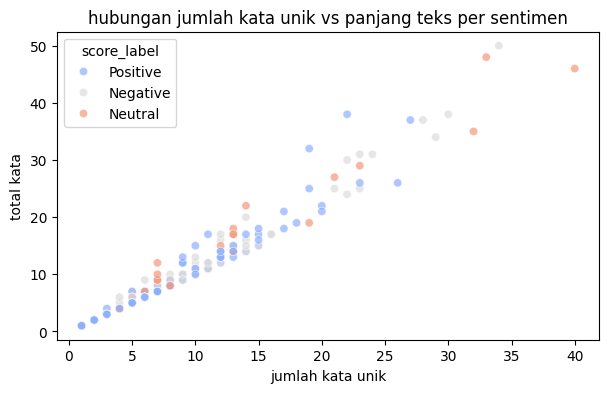

In [32]:
# ===========================================================
# 1️⃣5️⃣ hubungan kata unik vs panjang teks
# ===========================================================
df['unique_word_count'] = df['final_text'].apply(lambda x: len(set(x.split())))
plt.figure(figsize=(7,4))
sns.scatterplot(data=df, x='unique_word_count', y='word_count', hue='score_label', alpha=0.7, palette='coolwarm')
plt.title('hubungan jumlah kata unik vs panjang teks per sentimen')
plt.xlabel('jumlah kata unik')
plt.ylabel('total kata')
plt.show()

#🟩 **penutup**

seluruh tahapan eda dan analisis sentimen telah selesai dilakukan.  
hasil visualisasi dan statistik di atas dapat digunakan sebagai dasar  
untuk tahap analisis lanjutan atau pembuatan model klasifikasi sentimen. meskipun untuk saat ini tidak perlu lagi karena sudah memenuhi yg diminta untuk tugas ini.
